In [1]:
from nltk.corpus import brown
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import math
from itertools import combinations_with_replacement
import pandas as pd
import re
import pickle

In [2]:
# !nltk.download('brown')

In [3]:
# brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [4]:
# print(len(brown.sents(categories=['hobbies'])))
# ## too much, to lazy
# corpus_tokenize_ati_made_cannotdel_canu_haha = brown.sents(categories=['hobbies'])[:1500]
# print(corpus_tokenize_ati_made_cannotdel_canu_haha[-10])

4193
['Keep', 'it', 'no', 'longer', 'than', '36', 'hours', 'before', 'cooking', ',', 'and', 'keep', 'it', 'in', 'the', 'coldest', '(', 'but', 'non-freezing', ')', 'compartment', 'of', 'the', 'refrigerator', '.']


In [5]:
# vocab = list(set(flatten(corpus_tokenize_ati_made_cannotdel_canu_haha)))
# vocab[:4]
# vocab.append('<UNK>')
# word2index = {w: i for i, w in enumerate(vocab)}

# # print(word2index)
# voc_size = len(vocab)
# print(voc_size)

# index2word = {v:k for k, v in word2index.items()} 

6298


In [5]:
with open('wordtotrain_use.atikeep','rb') as pic:
    corpus_tokenize_ati_made_cannotdel_canu_haha,vocab,word2index,index2word = pickle.load(pic)
flatten = lambda l: [item for sublist in l for item in sublist]
voc_size = len(vocab)

## 2. Build Co-occurence Matrix X
- Here, we need to count the co-occurence of two words given some window size.  We gonna use window size of 1.

In [6]:


X_i = Counter(flatten(corpus_tokenize_ati_made_cannotdel_canu_haha)) # X_i
# X_i[:3]

In [7]:
# Make skip gram of one size window
skip_grams = []
# loop each word sequence
# we starts from 1 because 0 has no context
# we stop at second last for the same reason
for sent in corpus_tokenize_ati_made_cannotdel_canu_haha:
    for i in range(1, len(sent) - 1):
        target = sent[i]
        context = [sent[i - 1], sent[i + 1]]
        for w in context:
            skip_grams.append((target, w))

# skip_grams


X_ik_skipgram = Counter(skip_grams) # Co-occurece in window size 1
# X_ik_skipgram

### Weighting function

- ## Just like chakky do because chock copied directly

GloVe includes a weighting function to scale down too frequent words.

<img src = "../../Python-for-NLP/Code/01 - Fundamental/figures/glove_weighting_func.png" width=400>

In [8]:
#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [9]:


X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

# print(f"{X_ik=}")
# print(f"{weighting_dic=}")


## 3.prepare train data

In [10]:


def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

In [11]:
device = torch.device('cpu')

### testing the method

In [12]:
# x#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus_tokenize_ati_made_cannotdel_canu_haha, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

#we will convert them to tensor during training, so don't worry..

Input:  [[2735]
 [2012]]
Target:  [[  83]
 [1245]]
Cooc:  [[0.69314718]
 [0.69314718]]
Weighting:  [[0.05318296]
 [0.05318296]]


In [13]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [14]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
import time
if True:
# Training
    num_epochs = 5000
    times = 0
    for epoch in range(num_epochs):
        
        start = time.time()
        
        input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus_tokenize_ati_made_cannotdel_canu_haha, skip_grams, X_ik, weighting_dic)
        input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
        target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
        cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
        weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
        
        optimizer.zero_grad()
        loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
        
        loss.backward()
        optimizer.step()
        
        end = time.time()
        
        # epoch_mins, epoch_secs = epoch_time(start, end)
        times -= (start-end) 
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {start-end}s")
    print(f"end loss = {loss} + with time = {times} ")
    # torch.save(model.state_dict(), "myhobglove.pt")
    with open('myhobglove.atikeep', 'wb') as handle:
        pickle.dump((model), handle)

Epoch: 1000 | cost: 16.179327 | time: -0.018680095672607422s
Epoch: 2000 | cost: 16.347530 | time: -0.017574310302734375s
Epoch: 3000 | cost: 1.635131 | time: -0.01890087127685547s
Epoch: 4000 | cost: 1.975415 | time: -0.03319716453552246s
Epoch: 5000 | cost: 3.769938 | time: -0.021063804626464844s
end loss = 3.769937515258789 + with time = 104.4947772026062 


In [17]:
# model.load_state_dict("myhobglove.pt")
with open('myhobglove.atikeep', 'rb') as handle:
    model = pickle.load(handle)

In [18]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    # print(v_embed)
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

In [19]:
get_embed('longer')

(-0.4783579111099243, -1.01332688331604)

In [20]:
word2index['longer']

5441

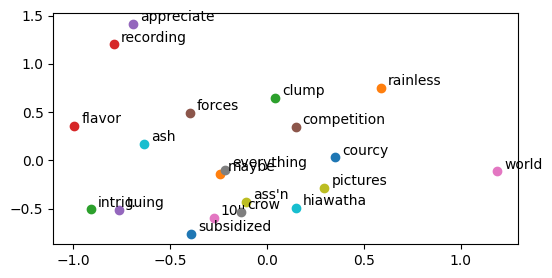

In [21]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [22]:
model.embedding_v(torch.tensor(1))

tensor([ 0.0812, -0.9284], grad_fn=<EmbeddingBackward0>)

In [23]:

# word = torch.LongTensor([word2index['ran']])
# word2 = torch.LongTensor([word2index['seldom']])

# m1 = model.embedding_v(word)[0].detach().numpy()
# m2 =model.embedding_v(word2)[0].detach().numpy()
# cos_sim(m1,m2) 

# cos_sim(get_embed_test('run'), get_embed_test('ran'))


# END OF FILE HERRE
-------------

In [24]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
def get_embed_test(word):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_v(word) + model.embedding_u(word))/2
    return np.array(embed[0].detach().numpy())

In [25]:
def find_analogy(a,b,c,vocab = vocab,model = model):
    emb_a, emb_b, emb_c = get_embed_test(a),get_embed_test(b),get_embed_test(c)
    vector = emb_b - emb_a + emb_c
    similarity = -1 
    retvoc = ''
    for voc in vocab:
        if voc not in [a,b,c]: 
            current_sim = cos_sim(vector,get_embed_test(voc))
            if current_sim > similarity:
                similarity = current_sim #update better one
                ret_voc = voc
                # print('hi')
    return ret_voc, similarity

In [26]:
# find_analogy('bud', 'create', 'point')

In [27]:
# with open('questions-words.txt','r') as 

text = open('questions-words.txt',mode='r')
df_ = pd.DataFrame(text.readlines())
header = df_[0].str.startswith(':')
index_list = np.where(header)[0].tolist()
print(index_list)
df = df_[8875:9867]

[0, 507, 5032, 5899, 8367, 8874, 9867, 10680, 12013, 13136, 14193, 15793, 17354, 18687]


In [28]:


def clean_data(df_col):
    corpus = []
    for item in df_col:
        item = re.sub('[^A-Za-z0-9]+', ' ', str(item)) # remove special characters
        item = item.lower() # lower all characters
        item = item.split() # split data
        corpus.append(' '.join(str(x) for x in item))
    return corpus

In [29]:
ctest = clean_data(df[0])
#data tokenized
tokenized_test = [sent.split(" ") for sent in ctest]
tokenized_test[:5]

[['amazing', 'amazingly', 'apparent', 'apparently'],
 ['amazing', 'amazingly', 'calm', 'calmly'],
 ['amazing', 'amazingly', 'cheerful', 'cheerfully'],
 ['amazing', 'amazingly', 'complete', 'completely'],
 ['amazing', 'amazingly', 'efficient', 'efficiently']]

In [30]:
data = pd.DataFrame(tokenized_test, columns=["A", "B", "C", "D"])
data.head()

,A,B,C,D
0,amazing,amazingly,apparent,apparently
1,amazing,amazingly,calm,calmly
2,amazing,amazingly,cheerful,cheerfully
3,amazing,amazingly,complete,completely
4,amazing,amazingly,efficient,efficiently


In [31]:
def analogy_accuracy(i,data = tokenized_test[:500]): #testing 
    corrects = 0
    total = len(data)
    for  a, b, c, d  in data :
        # a, b, c, d = row['A'],row['B'],row['C'],row['D']
        predict = find_analogy(a,b,c)[0] 
        if predict == d: 
            corrects +=1 
    acc = corrects/total
    return acc

In [32]:
analogy_accuracy('None')

KeyboardInterrupt: 